In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import time
import os
import random
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import tifffile

import cv2
import numpy as np
from matplotlib import pyplot as plt

from common import get_autoencoder, get_pdn_small, get_pdn_medium

In [2]:
# constants
on_gpu = torch.cuda.is_available()
out_channels = 384
image_size = 256

# data loading
default_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_teacher_norm_stats(model_dir):
    stats = torch.load(os.path.join(model_dir, "teacher_norm_stats.pth"), map_location="cpu")
    teacher_mean = stats['teacher_mean']  # shape [1, out_channels, 1, 1]
    teacher_std = stats['teacher_std']    # shape [1, out_channels, 1, 1]
    return teacher_mean, teacher_std

@torch.no_grad()
def predict(image, teacher, student, autoencoder, teacher_mean, teacher_std,
            q_st_start=None, q_st_end=None, q_ae_start=None, q_ae_end=None):
    teacher_output = teacher(image)
    teacher_output = (teacher_output - teacher_mean) / teacher_std
    student_output = student(image)
    autoencoder_output = autoencoder(image)
    map_st = torch.mean((teacher_output - student_output[:, :out_channels])**2,
                        dim=1, keepdim=True)
    map_ae = torch.mean((autoencoder_output -
                         student_output[:, out_channels:])**2,
                        dim=1, keepdim=True)
    if q_st_start is not None:
        map_st = 0.1 * (map_st - q_st_start) / (q_st_end - q_st_start)
    if q_ae_start is not None:
        map_ae = 0.1 * (map_ae - q_ae_start) / (q_ae_end - q_ae_start)
    map_combined = 0.5 * map_st + 0.5 * map_ae
    return map_combined, map_st, map_ae

@torch.no_grad()
def map_normalization(validation_loader, teacher, student, autoencoder,
                      teacher_mean, teacher_std, desc='Map normalization'):
    maps_st = []
    maps_ae = []
    # ignore augmented ae image
    for image, _ in tqdm(validation_loader, desc=desc):
        if on_gpu:
            image = image.cuda()
        map_combined, map_st, map_ae = predict(
            image=image, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std)
        maps_st.append(map_st)
        maps_ae.append(map_ae)
    maps_st = torch.cat(maps_st)
    maps_ae = torch.cat(maps_ae)
    q_st_start = torch.quantile(maps_st, q=0.9)
    q_st_end = torch.quantile(maps_st, q=0.995)
    q_ae_start = torch.quantile(maps_ae, q=0.9)
    q_ae_end = torch.quantile(maps_ae, q=0.995)
    return q_st_start, q_st_end, q_ae_start, q_ae_end

In [6]:
model_size = "small"
weight_path = 'output/1/trainings/mvtec_ad/capsule'

In [7]:
# if model_size == 'small':
#     teacher = get_pdn_small(out_channels)
#     student = get_pdn_small(2 * out_channels)
# elif model_size == 'medium':
#     teacher = get_pdn_medium(out_channels)
#     student = get_pdn_medium(2 * out_channels)
# else:
#     raise Exception()

teacher     = torch.load(weight_path + "/teacher_final.pth", map_location='cpu',weights_only=False)
student     = torch.load(weight_path + "/student_final.pth", map_location="cpu",weights_only=False)
autoencoder = torch.load(weight_path + "/autoencoder_final.pth", map_location="cpu",weights_only=False)
teacher_mean, teacher_std = load_teacher_norm_stats(weight_path)

device = None
if on_gpu == True:
    device = "cuda"
else:
    device = "cpu"

teacher=teacher.to(device)
student=student.to(device)
autoencoder=autoencoder.to(device)
teacher_mean=teacher_mean.to(device)
teacher_std=teacher_std.to(device)

# run intermediate evaluation
teacher.eval()
student.eval()
autoencoder.eval()
print("eval done.")

C:\Users\ksg\AppData\Local\Temp\ipykernel_19124\2746825783.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stats = torch.load(os.path.join(model_dir, "teacher_norm_stat

eval done.


# inference Code

In [36]:
TEST_IMG_PATH = "./datasets/MVTec/capsule/test/crack/006.png"
origin_image = Image.open(TEST_IMG_PATH)
image = default_transform(origin_image)
image = image.cuda()
image = image.unsqueeze(0)

In [37]:
start = time.time()
map_combined, map_st, map_ae = predict(
        image=image, teacher=teacher, student=student,
        autoencoder=autoencoder, teacher_mean=teacher_mean,
        teacher_std=teacher_std)
end = time.time()

print("inference_time : ", end-start)

result = map_combined.cpu().numpy()
result = result.squeeze()

inference_time :  0.002999544143676758


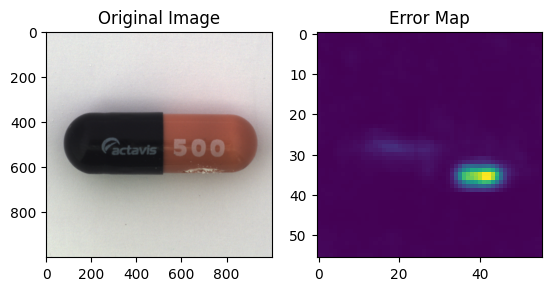

In [38]:
fig = plt.figure()
rows =1
cols = 2
ax1 = fig.add_subplot(rows, cols, 1)
ax1.set_title("Original Image")
ax1.imshow(origin_image)
ax2 = fig.add_subplot(rows, cols, 2)
ax2.set_title("Error Map")
ax2.imshow(result)

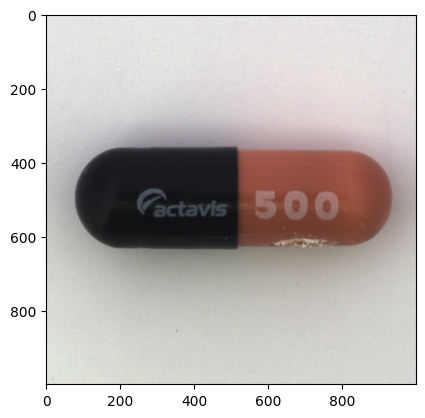

In [39]:
plt.imshow(origin_image)